In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pickle
import pandas as pd 
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score,f1_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

## 1. Loading, Processing and Splitting Data

In [2]:
df = pd.read_csv(r".\NUS_IT\Train_Set.csv")
test_df = pd.read_csv(r".\NUS_IT\Test_Set.csv")
print("Dimensions of DataFrame:",df.shape)
df.head()

Dimensions of DataFrame: (2193, 351)


,length_51,length_52,length_53,length_54,length_55,length_56,length_57,length_58,length_59,length_60,...,length_392,length_393,length_394,length_395,length_396,length_397,length_398,length_399,length_400,class_label
0,0.000152,0.000082,0.000087,0.000092,0.000099,0.000125,0.000122,0.000115,0.000151,0.000167,...,0.007396,0.007193,0.006973,0.006481,0.006139,0.005958,0.005578,0.005327,0.005142,healthy
1,0.006256,0.006413,0.006512,0.006469,0.006810,0.007070,0.007748,0.008088,0.008671,0.008835,...,0.017830,0.017033,0.016373,0.015371,0.014340,0.013975,0.013243,0.012725,0.012267,healthy
2,0.003783,0.003886,0.004063,0.004237,0.004481,0.004832,0.004960,0.005605,0.005919,0.006480,...,0.010957,0.010481,0.009782,0.009211,0.008800,0.008320,0.007869,0.007286,0.007020,healthy
3,0.004635,0.004471,0.004383,0.004829,0.004920,0.005056,0.005475,0.006158,0.007174,0.007697,...,0.010032,0.008933,0.008970,0.008546,0.008125,0.007587,0.007501,0.006931,0.006663,healthy
4,0.011315,0.010045,0.009795,0.009906,0.010630,0.011467,0.013024,0.014853,0.016874,0.017501,...,0.009118,0.008535,0.008233,0.007754,0.007584,0.006933,0.006530,0.006378,0.005842,healthy


In [3]:
## Checking the number of columns with missing values 
df.columns[df.isna().sum()>0] # no columns with any missing values 

Index([], dtype='object')

In [4]:
df.dtypes.value_counts() 
# 350 columns with float dtypes (decimal type); 
# 1 of which is non-numeric ('class_label') >> target column

float64    350
object       1
Name: count, dtype: int64

In [5]:
df['class_label'].value_counts() 
# imbalanced dataset; either will upsample using SMOTE/ oversampling / class weights
# last approach preferable

class_label
early stage cancer        781
screening stage cancer    490
mid stage cancer          453
late stage cancer         409
healthy                    60
Name: count, dtype: int64

In [6]:
dic={"healthy":1,"screening stage cancer":1,"early stage cancer":2,"mid stage cancer":3,"late stage cancer":4} 
# presumption is that screening stage is before early stage --> 
# no development of cancer certain; only being checked
# will equate that with healthy stage
# split of healthy and screening stage cancer will be performed later
# help to mitigate misclassification of other classes aggregated together
df['class_label'].map(dic).value_counts() # mapped appropriately

class_label
2    781
1    550
3    453
4    409
Name: count, dtype: int64

In [7]:
df['class_label'] = df['class_label'].map(dic)           
# changes the class_label column to numeric (ML model requires numeric data)
test_df['class_label'] = test_df['class_label'].map(dic) 
# likewise for the class_label column in the calidation dataset (test_df)

In [8]:
#### --> train test split first (from only the train data csv ; test data csv will be used for testing (unseen data))
r_state = 27 # for reproductibility of code
target = "class_label" 
# for benefit of ez reference >> as opposed to always typing "class_label"
X_features=[i for i in df.columns if i!=target] 
# all independent features

val_p = 0.35

X_train,X_test,y_train,y_test= train_test_split(df[X_features],df[target],test_size=val_p,stratify=df[target],random_state = r_state)
df = pd.concat([X_train,y_train],axis=1) 
# train dataset
dfv = pd.concat([X_test,y_test],axis=1) 
# validation dataset

Based on the train_set csv file, no data has to be imputed owing to all columns being fully filled. 
350/351 columns are also numeric; with only the taget column (class_label) being ordinal; and thus requiring Label Encoding 
performed manually using a dictionary. 

For the encoding of this column, both Healthy and Screening Stage patients are initially assigned 
to the same category (Healthy/Screening Stage). They will be split later using a secondary model.
The purpose for grouping the above 2 classes specifically first is to prevent severe imbalances of the dataset that could occur instead
if all cancer classes (screening stage, early stage, mid stage and late stage) were conglomerated into 1 class and healthy in another class. Furthermore, with the investigated literature pointing towards most people in the screening stage of cancer likely being healthy, we find that such a measure is more realistic and explainable than any other.

With all classes having a various number of samples
that isn't balanced - the weighting of classes and possibly some for of oversampling will be used in the training of models to overcome this problem. SMOTE was considered; however given the fact that the data concerns cancer stages and the data created by SMOTE is synthetic and thus subject to blur the boundaries between the different stages of cancer even more, the idea was put aside. 

## 2. Identifying Important Features and Model Comparisons

In [9]:
model = RandomForestClassifier(random_state=r_state,class_weight='balanced')
model.fit(df[X_features], df[target])
sig_features = model.feature_importances_ # importance of each feature obtained using Random Forest Classifier
feature_scores = sorted([(i,e) for i,e in enumerate(sig_features)],key=lambda x:x[-1],reverse=True)
forest_features = df.columns[list(map(lambda x:x[0],feature_scores))]

In [10]:
# Also will take a while as model is being trained
def model_trainer(df,dfv,best_cols):
    dt_clf  = DecisionTreeClassifier(random_state=r_state,class_weight='balanced')
    dt_clf.fit(df[best_cols],df[target])

    rf_clf  = RandomForestClassifier(random_state=r_state,class_weight='balanced')
    rf_clf.fit(df[best_cols],df[target])

    gb_clf = GradientBoostingClassifier(random_state=r_state)
    gb_clf.fit(df[best_cols],df[target])

    svm_clf = SVC(random_state=r_state,gamma='scale')
    svm_clf.fit(df[best_cols],df[target])
    
    sqrt_n = ((df.shape[0])**0.5)//1
    sqrt_n = int(sqrt_n + (1 if sqrt_n%2==0 else 0))
    knn_clf = KNeighborsClassifier(n_neighbors = sqrt_n)
    knn_clf.fit(df[best_cols],df[target])

    dt_pred  = dt_clf.predict(dfv[best_cols])
    rf_pred  = rf_clf.predict(dfv[best_cols])
    gb_pred = gb_clf.predict(dfv[best_cols])
    svm_pred = svm_clf.predict(dfv[best_cols])
    knn_pred = knn_clf.predict(dfv[best_cols])

    reverse_lis = [k for k,v in sorted(dic.items(),key=lambda x:x[-1])]
    reverse_lis = [reverse_lis[0]+'/'+reverse_lis[1]]+reverse_lis[2:]
    
    print("Decision Tree Report:")
    dt_r = classification_report(dfv[target],dt_pred,target_names = reverse_lis)
    print(dt_r)
    print("Random Forest Report:")
    rf_r = classification_report(dfv[target],rf_pred,target_names = reverse_lis)
    print(rf_r)
    print("GBoost Report:")
    xg_r = classification_report(dfv[target],gb_pred,target_names = reverse_lis)
    print(xg_r)
    print("SVM Report:")
    sv_r = classification_report(dfv[target],svm_pred,target_names = reverse_lis)
    print(sv_r)
    print("KNN Report:")
    kn_r = classification_report(dfv[target],knn_pred,target_names = reverse_lis)
    print(kn_r)
    return [dt_r,rf_r,xg_r,sv_r,kn_r]

5 different ML models are utilised - Decision Trees, Random Forest, Gradient Boosting, K nearest neighbours (KNN) and Support Vector Machines (SVM).

The metrics from sklearn's classification reports are used as a standard to compare the performances of the models, 
notably with the f1 score. Given that the data has already been normalised as per the README document sent alongside these datasets, we felt that further normalisation/ standardisation measures were not required. This is also heightened by the fact that we chose 3 tree based models which are generally accepted to be more robust to all types of data - even those that are not standardised/ normalised

Models with significantly poorer f1 score results will be removed further on and hyperparameter
tuning will be performed on the best-performing model from the 5 selected above.

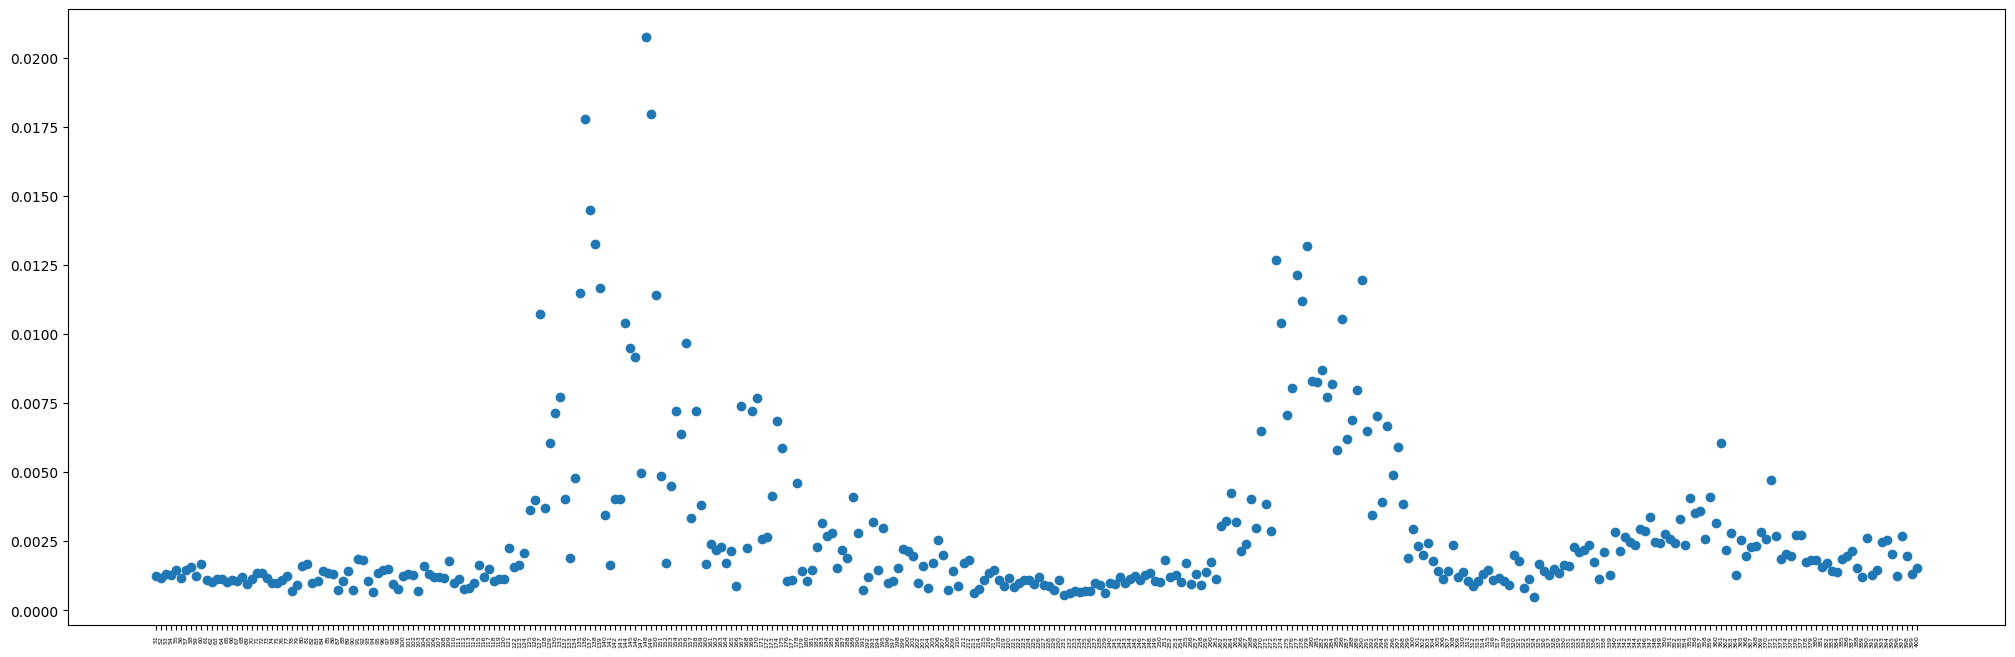

In [11]:
scores_by_cols = sorted(list(zip(forest_features,map(lambda x:x[-1],feature_scores))),key=lambda x:int(x[0].split('_')[-1]))
colnames = list(map(lambda x:x[0].split('_')[-1],scores_by_cols))
scores = list(map(lambda x:x[1],scores_by_cols))
plt.figure(figsize=(25,8))
plt.scatter(colnames,scores)
plt.xticks(rotation=90)
plt.tick_params(axis='x',labelsize=4.5)
plt.show() # plot of the importance of each feature with relation to each class is shown

In the meanwhile, the feature scores of the different independent columns are observed - with the aim being to identify a benchmark
at which a number of features can be chosen to grant good performance for the final ML model without requiring too many features to be selected - avoiding the [curse of dimensionality](https://dataloop.ai/blog/the-curse-of-dimensionality-dimension-reduction/#:~:text=The%20curse%20of%20dimensionality%20refers,features%20that%20exist%20in%20it).

However, instead of arbitrarily deciding a threshold on our own, we decided to choose the top-n features (based off their feature scores) and observe the performance of the results as we concede that the dataset is relatively small with regards to the number of data points and it is possible that most, if not all, of the features are essential in helping to ensure good classification

In [12]:
scores = np.array(scores)
print(f"Median Score: {np.median(scores)}")
print(f"Mean Score  : {np.mean(scores)}")
iqr = np.quantile(scores,(0.25,0.75))
print(f"Scores at 25th percentile: {iqr[0]:.6f} and\n\t  75th percentile: {iqr[-1]:.6f}")

Median Score: 0.0017065162269242935
Mean Score  : 0.002857142857142857
Scores at 25th percentile: 0.001150 and
	  75th percentile: 0.002920


In [13]:
above_75th = len(scores[scores>=iqr[1]])
above_mean = len(scores[scores>=np.mean(scores)])
above_median = len(scores[scores>=np.median(scores)])
above_25th = len(scores[scores>=iqr[0]])
above_p = [('25th percentile',above_25th),('median',above_median),('mean',above_mean),('75th percentile',above_75th)]
print("Number of Features with scores\n" +'\n'.join([f'above the {i[0]:<16}: '+str(i[-1]) for i in above_p]))
# aim to look at number of top n-ranked features where n is 
# a number from 90 - 275 >> basis of comparison against all features (350)

Number of Features with scores
above the 25th percentile : 262
above the median          : 175
above the mean            : 90
above the 75th percentile : 88


Given how there are 88 features with a score above the 75th percentile of the scores of all features and 262 features with a score above the 25th percentile, we aim to observe the performance of our ML models based on set changes in the number of features used in our dataset and compare the average f1 score for accuracy, macro avg and weighted avg amongst all the models

In [14]:
# code cell runs for abt 9 - 15 min 
d={}
no_of_features = [90,100,125,150,175,225,250,275,350]
for i in no_of_features: 
    print(f"Top {i} features")
    best_cols = forest_features[:i]
    l = model_trainer(df,dfv,best_cols) 
    a = list(map(lambda x:x.strip().split('\n'),l))
    k = ['Decision Tree','Random Forest','GBoost','SVM','KNN']
    for n,e in enumerate(a):
        key = f"{i} - {(k[n])}"
        z=[float(i[-1]) for i in list(map(lambda x:re.findall("\d\.\d\d",x),e)) if len(i)>0]
        d[key] = z
# Already apparent out of the gate that Decision Tree, Random Forest 
# and GBoost Models perform significantly better than SVM & KNN models

Top 90 features


  File "c:\Users\ruoyu\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.83      0.83      0.83       193
            early stage cancer       0.80      0.81      0.80       273
              mid stage cancer       0.73      0.74      0.73       159
             late stage cancer       0.91      0.87      0.89       143

                      accuracy                           0.81       768
                     macro avg       0.82      0.81      0.81       768
                  weighted avg       0.81      0.81      0.81       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.86      0.89      0.87       193
            early stage cancer       0.85      0.85      0.85       273
              mid stage cancer       0.78      0.81      0.79       159
             late stage cancer       0.93      0.85      0.89       143

               

KeyboardInterrupt: 

In [ ]:
features = sorted(set(map(lambda x:int(x.split('-')[0].strip()),d.keys())))
models = list(map(lambda x:(x.split('-')[-1].strip()),d.keys()))[:5]
data=[]
for e in features:
    li=[e]
    for m in models:
        li.append(sum(d[f"{e} - {m}"][:4])/4) 
    data.append(li) 
# average f1 score of the classes (healthy/screening stage, early stage, mid stage, late stage) 
# of different ML models with different number of features is calculated and displayed in bar graph below

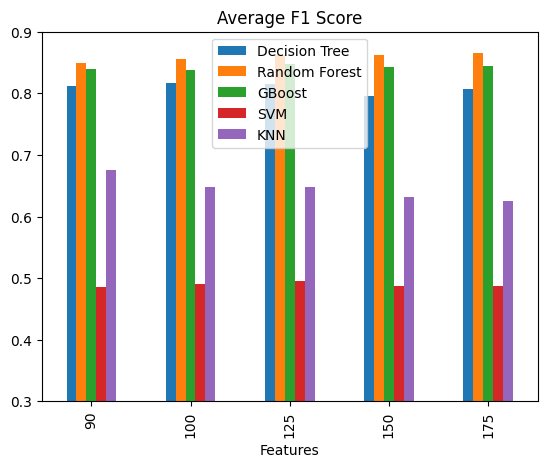

In [ ]:
tf = pd.DataFrame(data, columns=['Features']+models)
tf.plot(x='Features', 
        kind='bar', 
        stacked=False, 
        title='Average F1 Score')
plt.ylim(bottom=0.3,top=0.9)
plt.show() 
# significantly apparent that Decision Tree, Random Forest 
# and GBoost (Gradient Boosting) classifiers perform better han SVM and KNN 
# >> will remove the latter 2 instances and focus on the former 3

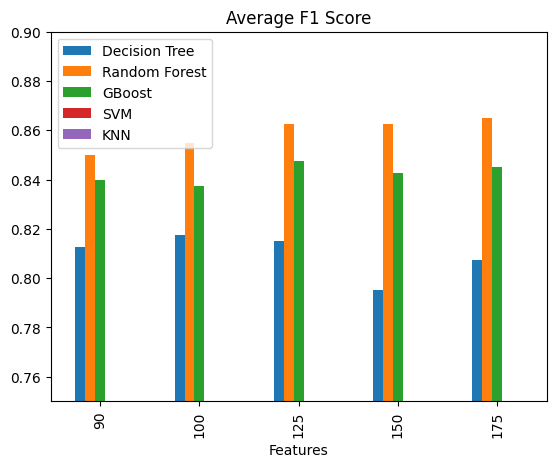

In [ ]:
tf.plot(x='Features', 
        kind='bar', 
        stacked=False, 
        title='Average F1 Score')
plt.ylim(bottom=0.75,top=0.9)
plt.show()
# clear that amongst all the models, Random Forest (RF) performs the best; 
# also apparent that at best results are at 350 features for Random forest - 
# indicative that presence of all features can be useful in coming up with a good model


In [ ]:
best_cols = forest_features # looking at all of the featurs (alll columns)

## 3. Model Training and Hyperparameter Evaluation

In [ ]:
reverse_lis = [k for k,_ in sorted(dic.items(),key=lambda x:x[-1])]
reverse_lis = [reverse_lis[0]+'/'+reverse_lis[1]]+reverse_lis[2:] 

Based on some experimentation and research, our group has decided to utilise a hierarchical classification approach with 2 models, a primary model to classify the data into 4 classes -> **healthy/screening stage cancer**, **early stage cancer**, **mid stage cancer**, **late stage cancer**. 

The predicted results belonging to the first class, **healthy/screening stage cancer**, would then be fed into a secondary model to be further split into 2 classes -> **healthy** and **screening stage cancer**, such that all 5 distinct classes would be obtained. The reason for choosing such an approach is due to the enhanced performance this multi-model approach grants as opposed to using just 1 model in terms of overall precision and accuracy, while retaining generalisability and explainability.

### 3.1 Primary Model

In [ ]:
params = {'bootstrap': [True,False],
 'max_depth': [50, 75, 100, None],
 'min_samples_split': [2, 5],
 'criterion':['gini','entropy','log_loss'],
 'n_estimators': [100,200,300]}

def f1_eval(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

f1_scorer = make_scorer(f1_eval, greater_is_better=True)

rf_grid = GridSearchCV(estimator = RandomForestClassifier(random_state=r_state,class_weight='balanced'), param_grid= params, 
                        cv = StratifiedKFold(n_splits=5,random_state=r_state,shuffle=True),scoring = f1_scorer,n_jobs=-1)
# Grid Search CV is used to evaluate ALL narrowed down parameters to give optimised result

With the Random Forest Classifier having the best performance for classifying the various cancer stages, Grid Search Cross Validation is employed with the above hyperparameters in the `params` dictionary being used to enhance the model's performance. The f1 metric used is as a scorer for different models as we want to optimise both the *precision* (% of TP/(TP+FP)) and *recall* (% of TP/(TP+FN)) of all classes in the model. Stratified K-Fold Cross Validation is also used in order to assess each hyperparameterised model's performance on multiple validation sets.

In [ ]:
# takes about 15-30 min to run this code cell
"""
rf_grid.fit(df[best_cols],df[target]) 
print(rf_grid.best_params_)
"""
# may remove the string quotes to run the code; doing so will lengthen the runtime of the file

### Observed Output ###
# {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 300}

'\nrf_grid.fit(df[best_cols],df[target]) \nprint(rf_grid.best_params_)\n'

In [ ]:
rf_b = RandomForestClassifier(random_state=r_state,class_weight='balanced')
rf_b.fit(df[best_cols],df[target]) 
y_pred_base = rf_b.predict(dfv[best_cols])
print(classification_report(dfv[target],y_pred_base,target_names = reverse_lis)) 
# performance of base model on validation set (dfv)

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.88      0.91      0.89       193
            early stage cancer       0.87      0.88      0.87       273
              mid stage cancer       0.83      0.82      0.83       159
             late stage cancer       0.95      0.87      0.91       143

                      accuracy                           0.88       768
                     macro avg       0.88      0.87      0.88       768
                  weighted avg       0.88      0.88      0.88       768



In [ ]:
rf_h = RandomForestClassifier(random_state=r_state,max_depth = 50,max_leaf_nodes = None,min_samples_split = 5,
    n_estimators = 300,class_weight='balanced',criterion='entropy',bootstrap=False)
rf_h.fit(df[best_cols],df[target]) 
y_pred_hyper = rf_h.predict(dfv[best_cols])
print(classification_report(dfv[target],y_pred_hyper,target_names = reverse_lis)) 
# performance of hyperparameterised model on validation set (dfv)
# hyperparameter model performs marginally better to original model >> regardless, better f1 performance

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.89      0.92      0.90       193
            early stage cancer       0.89      0.89      0.89       273
              mid stage cancer       0.84      0.86      0.85       159
             late stage cancer       0.95      0.87      0.91       143

                      accuracy                           0.89       768
                     macro avg       0.89      0.89      0.89       768
                  weighted avg       0.89      0.89      0.89       768



In [ ]:
# performance of base model on test set (unseen data)
print(classification_report(test_df[target],rf_b.predict(test_df[best_cols]) ,target_names = reverse_lis))

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.76      0.56      0.64       271
            early stage cancer       0.63      0.73      0.67       368
              mid stage cancer       0.62      0.73      0.67       206
             late stage cancer       0.89      0.79      0.83       189

                      accuracy                           0.69      1034
                     macro avg       0.73      0.70      0.71      1034
                  weighted avg       0.71      0.69      0.70      1034



In [ ]:
# performance of hyperparameterised model on test set (unseen data)
print(classification_report(test_df[target],rf_h.predict(test_df[best_cols]),target_names = reverse_lis))
# hyperparametised model performs slightly BETTER on test set wrt f1 score
# than base/default model with no change to parameters; will use it for sure

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.76      0.56      0.64       271
            early stage cancer       0.64      0.72      0.68       368
              mid stage cancer       0.62      0.76      0.68       206
             late stage cancer       0.89      0.78      0.83       189

                      accuracy                           0.70      1034
                     macro avg       0.72      0.70      0.71      1034
                  weighted avg       0.71      0.70      0.70      1034



### 3.2 Secondary Model

In [ ]:
db = pd.read_csv(r".\NUS_IT\Train_Set.csv")
test_db = pd.read_csv(r".\NUS_IT\Test_Set.csv")

db = db[db[target].isin(['healthy','screening stage cancer'])].copy() 
# secondar mode is trained only on instances whereby the `class_label` is either healthy / screening stage cancer
val_p = 0.25 # slightly smaller validation set percentage to account for the smaller data size 
# --> allow the training set to be bigger

dic2 = {'healthy':0,'screening stage cancer':1}
db[target] = db[target].map(dic2)

X_train,X_test,y_train,y_test= train_test_split(db[X_features],db[target],test_size=val_p,stratify=db[target],random_state = r_state)
ros = RandomOverSampler(random_state = r_state,sampling_strategy=0.75) 
# because the initial sample size of data is so much significantly smaller, 
# some oversampling for the minority class is also performed 
X_train,y_train = ros.fit_resample(X_train,y_train)
db = pd.concat([X_train,y_train],axis=1) 
# train dataset
dbv = pd.concat([X_test,y_test],axis=1) 
# validation dataset
best_cols = forest_features
db[target].value_counts()

class_label
1    367
0    275
Name: count, dtype: int64

In [ ]:
## comparison of different models for binary classification

lr = LogisticRegression(class_weight='balanced',random_state=r_state) # default of logistic regression
lr.fit(db[best_cols],db[target])
print("Logistic Regression Model:")
print(classification_report(dbv[target],lr.predict(dbv[best_cols]),target_names=dic2.keys()))
# top 3 performing models (Random forest, Gradient Boost & Decision Tree) previously utilised 
# used again in hopes of similar performance
print("\nRandom Forest Model:")
rf = RandomForestClassifier(class_weight='balanced',random_state=r_state)
rf.fit(db[best_cols],db[target])
print(classification_report(dbv[target],rf.predict(dbv[best_cols]),target_names=dic2.keys()))
print("\nDecision Tree Model:")
dt = DecisionTreeClassifier(class_weight='balanced',random_state=r_state)
dt.fit(db[best_cols],db[target])
print(classification_report(dbv[target],dt.predict(dbv[best_cols]),target_names=dic2.keys()))
print("\nGradient Boosting Model:")
gb = GradientBoostingClassifier(random_state=r_state)
gb.fit(db[best_cols],db[target])
print(classification_report(dbv[target],gb.predict(dbv[best_cols]),target_names=dic2.keys()))
# results indicate how precision and recall for healthy samples will be significantly lower -> best 
# results so far are for Gradient Boosting model

# metric used to evaluate performance of the model this time is precision; owing to greater priority of 
# people being classified as healthy actually BEING healthy (TP) as opposed to requiring screening (FP)

# all columns reused

Logistic Regression Model:
                        precision    recall  f1-score   support

               healthy       0.13      0.53      0.21        15
screening stage cancer       0.91      0.55      0.69       123

              accuracy                           0.55       138
             macro avg       0.52      0.54      0.45       138
          weighted avg       0.82      0.55      0.63       138


Random Forest Model:
                        precision    recall  f1-score   support

               healthy       0.10      0.07      0.08        15
screening stage cancer       0.89      0.93      0.91       123

              accuracy                           0.83       138
             macro avg       0.50      0.50      0.49       138
          weighted avg       0.80      0.83      0.82       138


Decision Tree Model:
                        precision    recall  f1-score   support

               healthy       0.18      0.13      0.15        15
screening stage cancer    

In [ ]:
params2 = {
    'loss':['log_loss','exponential'],
    'criterion':['friedman_mse','squared_error'],
    'n_estimators':[100,200,300],
    'max_depth':[2,3,5,7],
    'subsample':[0.5,0.75,1]}

def precision_eval(y_true, y_pred): # scoring metric of precision used
    precision = precision_score(y_true, (y_pred > 0.5),pos_label=0)
    return precision

scorer = make_scorer(precision_eval)
gb_grid = GridSearchCV(estimator = GradientBoostingClassifier(random_state=r_state), param_grid= params2, 
                        cv = StratifiedKFold(n_splits=3,random_state=r_state,shuffle=True), scoring = scorer, n_jobs=-1)
# Grid Search CV used again for hyperparameter tuning of Gradient Boost model

In [ ]:
# takes about 15 - 30 minutes to run
"""
gb_grid.fit(db[best_cols],db[target]) 
print(gb_grid.best_params_)
"""
# may remove the string quotes to run the code; doing so will lengthen the runtime of the file

## Output ##
# {'criterion': 'squared_error', 'loss': 'log_loss', 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.75}

'\ngb_grid.fit(db[best_cols],db[target]) \nprint(gb_grid.best_params_)\n'

In [ ]:
gb_h = GradientBoostingClassifier(random_state=r_state,n_estimators=100,max_depth=5,loss='log_loss',subsample = 0.75, criterion='squared_error')
gb_h.fit(db[best_cols],db[target])

GradientBoostingClassifier(criterion='squared_error', max_depth=5,
                           random_state=27, subsample=0.75)

In [ ]:
test_db = test_db[test_db[target].isin(['healthy','screening stage cancer'])].copy()
test_db[target] = test_db[target].map(dic2) # evaluation of hyperparameterised model to be evaluated on test set

In [ ]:
print(classification_report(test_db[target],gb.predict(test_db[best_cols]),target_names=dic2.keys())) 
# performance of default Gradient boost model on test set

                        precision    recall  f1-score   support

               healthy       0.37      0.27      0.31        41
screening stage cancer       0.88      0.92      0.90       230

              accuracy                           0.82       271
             macro avg       0.62      0.59      0.60       271
          weighted avg       0.80      0.82      0.81       271



In [ ]:
print(classification_report(test_db[target],gb_h.predict(test_db[best_cols]),target_names=dic2.keys()))
# performance of hyperparamterised Gradient boost model on test set --> better precision especially for healthy samples

                        precision    recall  f1-score   support

               healthy       0.56      0.22      0.32        41
screening stage cancer       0.87      0.97      0.92       230

              accuracy                           0.86       271
             macro avg       0.72      0.59      0.62       271
          weighted avg       0.83      0.86      0.83       271



In [ ]:
primary_model = rf_h
secondary_model = gb_h

## 4. Evaluating & Saving the final models

In [ ]:
val_df = pd.concat([dbv,dfv[dfv[target]!=1]],axis=0) # Evaluating model performance on shared validation set data
val_df = val_df.reset_index().drop(columns='index')
colnames = primary_model.feature_names_in_ 
pred_pri = primary_model.predict(val_df[colnames])
pred_healthy_or_screening_idx = list(map(lambda x:x[0],filter(lambda x:x[-1]==1,[(i,e) for i,e in enumerate(list(pred_pri))])))
# code to find the indexes in the predicted output where the prediction is 1 
# (healthy/screening stage) for secondary model to split
pred_pri_cfm = list(filter(lambda x:x[-1]!=1,[(i,e) for i,e in enumerate(list(pred_pri))]))

val_df2 = val_df[val_df.index.isin(pred_healthy_or_screening_idx)].copy()
colnames = secondary_model.feature_names_in_ # get the columns required for the secondary model (same as primary model)
pred_sec = secondary_model.predict(val_df2[colnames])
pred_sec_cfm = list(zip(val_df2.index,pred_sec)) # merge index number w prediction status
pred_res = sorted(pred_pri_cfm + pred_sec_cfm,key=lambda x:x[0])

pred = pd.Series(list(map(lambda x:x[1],pred_res)))

pred.name = 'predicted'
print(classification_report(val_df[target],pred,
    target_names=['healthy', 'screening stage cancer', 'early stage cancer', 'mid stage cancer', 'late stage cancer']))
# performance for healthy set isn't great >> but notable that there is limited sample size (15s data points) 
# >> can't rule out poor performance yet
# indeed as support (number of data points) increases, evident that performance also increases for the other stages

                        precision    recall  f1-score   support

               healthy       0.00      0.00      0.00        15
screening stage cancer       0.75      0.95      0.84       123
    early stage cancer       0.94      0.89      0.92       273
      mid stage cancer       0.84      0.86      0.85       159
     late stage cancer       0.95      0.87      0.91       143

              accuracy                           0.87       713
             macro avg       0.70      0.71      0.70       713
          weighted avg       0.87      0.87      0.87       713



In [ ]:
### Evaluation of performance of both primary and secondary models together on test data (unseen data)

tf = pd.read_csv(r".\NUS_IT\Test_Set.csv")
tf = tf.reset_index().drop(columns='index') # to ensure test set/ any dataset parsed in for testing has its indices organised
colnames = primary_model.feature_names_in_ # get the columns required for the primary model
pred_pri = primary_model.predict(tf[colnames])
pred_healthy_or_screening_idx = list(map(lambda x:x[0],filter(lambda x:x[-1]==1,[(i,e) for i,e in enumerate(list(pred_pri))])))
# code to find the indexes in the predicted output where the prediction is 1 
# (healthy/screening stage) for secondary model to split
pred_pri_cfm = list(filter(lambda x:x[-1]!=1,[(i,e) for i,e in enumerate(list(pred_pri))]))
# other results are left as is
tf2 = tf[tf.index.isin(pred_healthy_or_screening_idx)].copy()
colnames = secondary_model.feature_names_in_ # get the columns required for the secondary model (same as primary model)
pred_sec = secondary_model.predict(tf2[colnames])
pred_sec_cfm = list(zip(tf2.index,pred_sec)) # merge index number w prediction status
pred_res = sorted(pred_pri_cfm + pred_sec_cfm,key=lambda x:x[0])
# all predictions are merged together and sorted based on index positions
reverse_dic = {0:'healthy',1:'screening stage cancer',2:'early stage cancer',3:'mid stage cancer',4:'late stage cancer'} 
# dictionary used to map numbers to category names
pred = pd.Series(list(map(lambda x:reverse_dic[x[1]],pred_res)))
pred.name = 'predicted'
print(classification_report(tf[target],pred))
# improved performance on healthy dataset; bit of a performance drop for screening and early cancer groups but not unexpected
# overall macro avg still holds well > could potentially be improved with inclusion of varied hyperparameters + definitely with
# more data points for train set and also with more 'back n forth' between layers of primary and secondary model

                        precision    recall  f1-score   support

    early stage cancer       0.64      0.72      0.68       368
               healthy       0.44      0.17      0.25        41
     late stage cancer       0.89      0.78      0.83       189
      mid stage cancer       0.62      0.76      0.68       206
screening stage cancer       0.65      0.52      0.57       230

              accuracy                           0.67      1034
             macro avg       0.64      0.59      0.60      1034
          weighted avg       0.67      0.67      0.67      1034



In [ ]:
# models are saved into pickle files
with open('CancerStagersPrimaryModel.pkl','wb') as f:
    pickle.dump(primary_model,f) 
with open('CancerStagersSecondaryModel.pkl','wb') as f:
    pickle.dump(secondary_model,f) 